In [1]:
#cifar
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras import layers
import os
import numpy as np 
from matplotlib import pyplot as plt
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%matplotlib inline

In [2]:
# create CNN
def CNNmodel(input_shape,filters=64, kernel=(3,3),size=4,dropout=0.2,**kwargs):
    _inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(8,(3,3),padding='same',use_bias=False,strides=(2,2), name='conv_0')(_inputs)
    x = layers.BatchNormalization(axis=-1, name='conv_0_bn')(x)
    x = layers.ReLU(6., name='conv_0_relu')(x)
    
    x = layers.Conv2D(16,(3,3),padding='same',use_bias=False,strides=(2,2), name='conv_1')(_inputs)
    x = layers.BatchNormalization(axis=-1, name='conv_1_bn')(x)
    x = layers.ReLU(6., name='conv_1_relu')(x)

    for block_id in range(2,size+2):
        x = layers.Conv2D(filters,kernel,padding='same',use_bias=False,strides=(1,1), name='conv_%d'%block_id)(x)
        x = layers.BatchNormalization(axis=-1, name='conv_%d_bn'%block_id)(x)
        x = layers.ReLU(6., name='conv_%d_relu'%block_id)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout, name='dropout')(x)
    x = layers.Dense(10)(x)
    x = layers.Softmax()(x)
    return keras.Model(inputs=_inputs,outputs=x)

In [ ]:
# preprocess input
def preprocess_input(inputs, std=255. ,mean=0., expand_dims=None):
    inputs = tf.cast(inputs,tf.float32)
    inputs = (inputs - mean) / std
    if expand_dims is not None:
        np.expand_dims(inputs,expand_dims)
    return inputs

# dataset aug
def img_aug_fun(elem):
    elem = tf.image.random_flip_left_right(elem)#左右翻转
    elem = tf.image.random_brightness(elem, max_delta=0.5)#调亮度
    elem = tf.image.random_contrast(elem, lower=0.5, upper=1.5)#调对比度
    elem = preprocess_input(elem)
    return elem

# load CIFAR10 dataset, size(32,32,3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

x_test = preprocess_input(x_test)
x_train_ds = tf.data.Dataset.from_tensor_slices(x_train).map(img_aug_fun)
y_train_ds = tf.data.Dataset.from_tensor_slices(y_train)
x_y_train_ds = tf.data.Dataset.zip((x_train_ds,y_train_ds))
x_y_train_ds = x_y_train_ds.batch(128)

 75063296/170498071 [============>.................] - ETA: 45:17

In [4]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=4, min_lr=0.0001,verbose=1)
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8,verbose=1)

model = CNNmodel(input_shape=(32,32,3),filters=64, kernel=(3,3),size=9)
model.compile(optimizer='SGD',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_y_train_ds,validation_data=(x_test,y_test),callbacks=[reduce_lr,earlystop],verbose=2,epochs=500)

Epoch 1/500
391/391 - 16s - loss: 2.0909 - accuracy: 0.2065 - val_loss: 2.2592 - val_accuracy: 0.1783
Epoch 2/500
391/391 - 14s - loss: 1.8456 - accuracy: 0.2953 - val_loss: 1.7214 - val_accuracy: 0.3429
Epoch 3/500
391/391 - 14s - loss: 1.7404 - accuracy: 0.3398 - val_loss: 1.5942 - val_accuracy: 0.4036
Epoch 4/500
391/391 - 14s - loss: 1.6547 - accuracy: 0.3804 - val_loss: 1.5128 - val_accuracy: 0.4618
Epoch 5/500
391/391 - 13s - loss: 1.5748 - accuracy: 0.4201 - val_loss: 1.4497 - val_accuracy: 0.4789
Epoch 6/500
391/391 - 14s - loss: 1.4948 - accuracy: 0.4522 - val_loss: 1.4727 - val_accuracy: 0.4683
Epoch 7/500
391/391 - 14s - loss: 1.4275 - accuracy: 0.4794 - val_loss: 1.4442 - val_accuracy: 0.4959
Epoch 8/500
391/391 - 14s - loss: 1.3667 - accuracy: 0.5058 - val_loss: 1.2725 - val_accuracy: 0.5290
Epoch 9/500
391/391 - 13s - loss: 1.3100 - accuracy: 0.5300 - val_loss: 1.4093 - val_accuracy: 0.4910
Epoch 10/500
391/391 - 13s - loss: 1.2610 - accuracy: 0.5464 - val_loss: 1.2455 - 

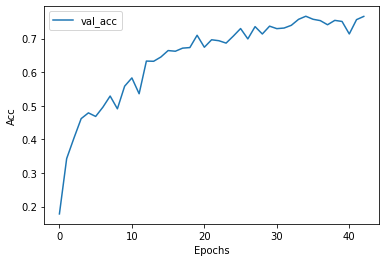

In [5]:
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

In [6]:
model.save('checkpoint/Cifar10_CNN_%.3f'%history.history['val_accuracy'][-1]+'.h5')